We will use the labeled faces in scikit learn wild database. It called as Olivetti Face, including faces images and mood labels. Our mission are facial recoginition, using supervised training to recognize the mood of the people in the photo.

In [2]:
# the olivetti face dataset
from sklearn.datasets import fetch_lfw_people

# feature extracting module
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# feature scaling module
from sklearn.preprocessing import StandardScaler

# regular Python module
from time import time
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
# make sure photo show in notebook

# scikit learn feature selection module
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# indicator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# machine learning module
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [3]:
# first parameter keep the photo reaching minimum for each class, resize are for changing photo size.
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# check array size 
n_samples, h, w = lfw_people.images.shape
n_samples, h, w

(1288, 50, 37)

In [4]:
# directly using, ignore relative pixel position
X = lfw_people.data
y = lfw_people.target
n_features = X.shape[1]

n_features

1850

In [5]:
X.shape

(1288, 1850)

'Hugo Chavez'

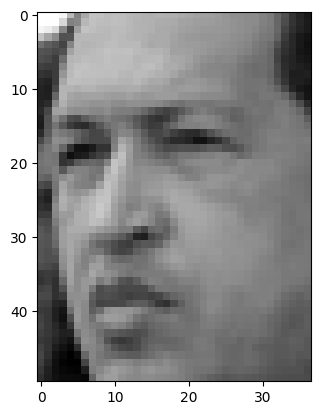

In [6]:
# plot one face
plt.imshow(X[0].reshape((h, w)), cmap=plt.cm.gray)
lfw_people.target_names[y[0]]

'Hugo Chavez'

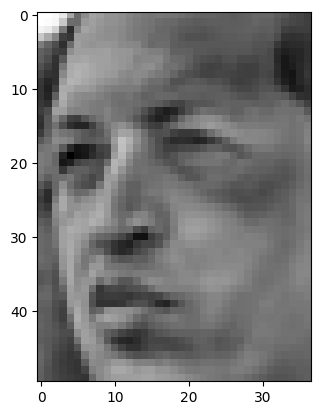

In [7]:
# scale first and show the image again
plt.imshow(StandardScaler().fit_transform(X)[0].reshape((h, w)), cmap=plt.cm.gray)
lfw_people.target_names[y[0]]

In [8]:
# set the label to predict the id of the person
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [9]:
# separate dataset to train and test, splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

# create PCA instantance
pca = PCA(n_components=200, whiten=True)

# create pipeline, scale data and use PCA
preprocessing = Pipeline([('scale', StandardScaler()), ('pca', pca)])

print("Extracting the top %d eigenfaces from %d faces" %(200, X_train.shape[0]))
#fitting
preprocessing.fit(X_train)
# extracting pca from pipeline
extracted_pca = preprocessing.steps[1][1]

Extracting the top 200 eigenfaces from 966 faces


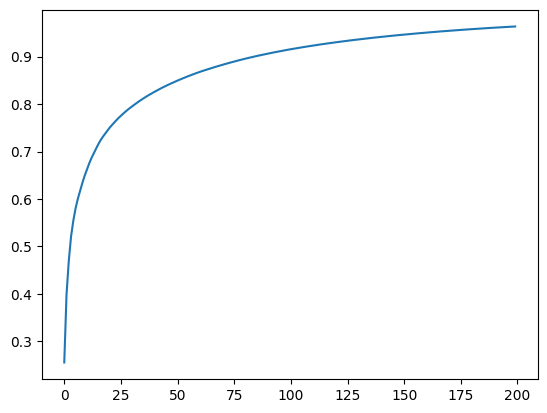

In [10]:
#check scatter plot:
plt.plot(np.cumsum(extracted_pca.explained_variance_ratio_))

In [11]:
# function to plot PCA
comp = extracted_pca.components_
image_shape = (h, w)
def plot_gallery(title, images, n_col, n_row):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i+1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray, vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    plt.show()

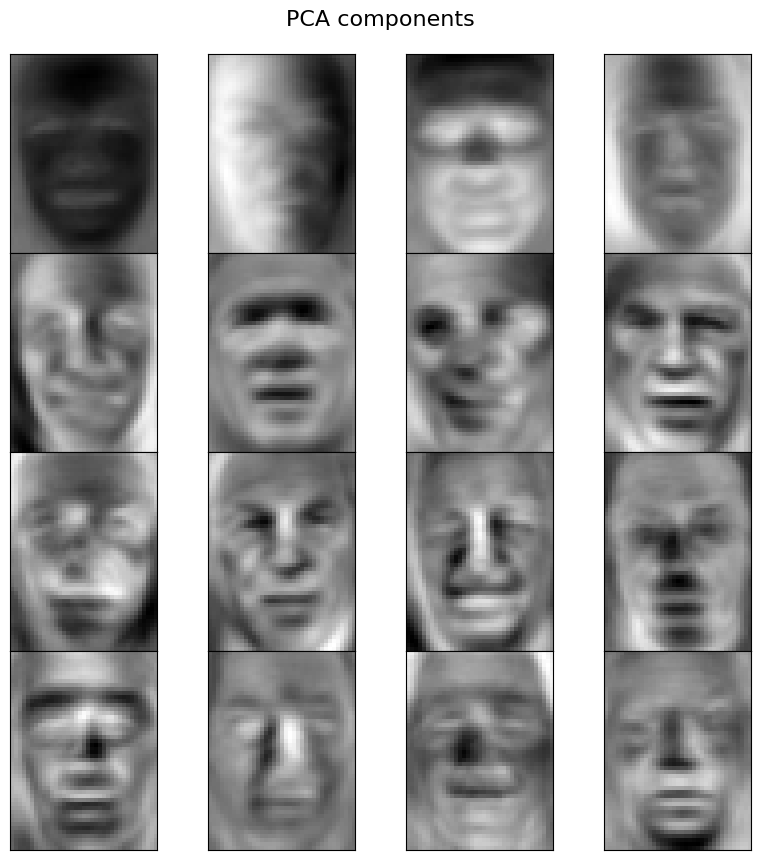

In [12]:
plot_gallery('PCA components', comp[:16], 4, 4)

These eigenface are similar to eigendigit in chapter 7. The photo in Col 4 row 3 specify the characteristic in moustache and beard. The photo in Col 4 row 1 specify the background lighting to the face.

In [13]:
import itertools

# plot confusion matrx, with heat labels and normalization options
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

0.8416149068322981 Accuracy score for best estimator
                   precision    recall  f1-score   support

     Ariel Sharon       0.80      0.84      0.82        19
     Colin Powell       0.89      0.76      0.82        55
  Donald Rumsfeld       0.69      0.72      0.71        25
    George W Bush       0.89      0.94      0.91       142
Gerhard Schroeder       0.78      0.81      0.79        31
      Hugo Chavez       0.88      0.88      0.88        16
       Tony Blair       0.72      0.68      0.70        34

         accuracy                           0.84       322
        macro avg       0.81      0.80      0.80       322
     weighted avg       0.84      0.84      0.84       322

None
1440.9 seconds to grid search and predict the test set


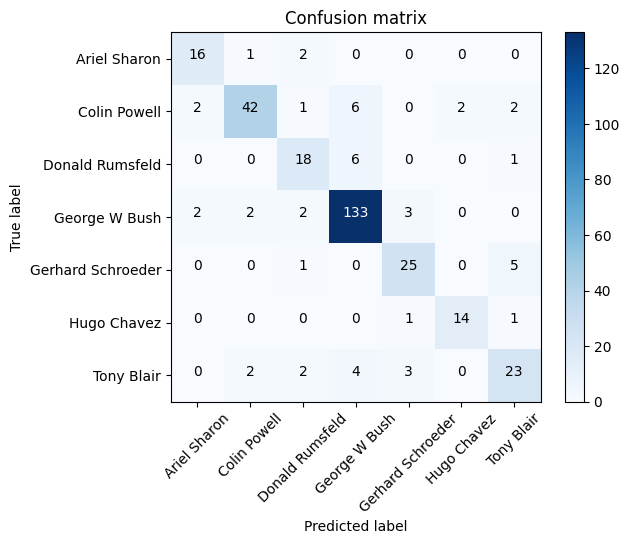

In [14]:
# now even don't use PCA can see the difference
t0 = time()

logreg = LogisticRegression(max_iter=10000)
param_grid = {'C': [1e-2, 1e-1, 1e0, 1e1, 1e2]}
clf = GridSearchCV(logreg, param_grid)
clf = clf.fit(X_train, y_train)
best_clf = clf.best_estimator_

# use test set to predict
y_pred = best_clf.predict(X_test)

print(accuracy_score(y_pred, y_test), "Accuracy score for best estimator")
print(classification_report(y_test, y_pred, target_names=target_names))
print(plot_confusion_matrix(confusion_matrix(y_test, y_pred, labels=range(n_classes)), target_names))
print(round((time() - t0), 1), "seconds to grid search and predict the test set")

In [17]:
# even using original method, we reach 81.3% accuracy, check the difference after using PCA, we set PCA element as 200
t0 = time()

face_pipeline = Pipeline(steps=[('PCA', PCA(n_components=200)), ('logistic', logreg)])
pipe_param_grid = {'logistic__C':[1e-2, 1e-1, 1e0, 1e1, 1e2]}
clf = GridSearchCV(face_pipeline, pipe_param_grid)
clf = clf.fit(X_train, y_train)
best_clf = clf.best_estimator_

0.8540372670807453 Accuracy score for best estimator
                   precision    recall  f1-score   support

     Ariel Sharon       0.84      0.84      0.84        19
     Colin Powell       0.89      0.76      0.82        55
  Donald Rumsfeld       0.65      0.80      0.71        25
    George W Bush       0.90      0.93      0.91       142
Gerhard Schroeder       0.78      0.90      0.84        31
      Hugo Chavez       0.93      0.88      0.90        16
       Tony Blair       0.85      0.68      0.75        34

         accuracy                           0.85       322
        macro avg       0.83      0.83      0.83       322
     weighted avg       0.86      0.85      0.85       322

None
25.2 seconds to grid search and predict the test set


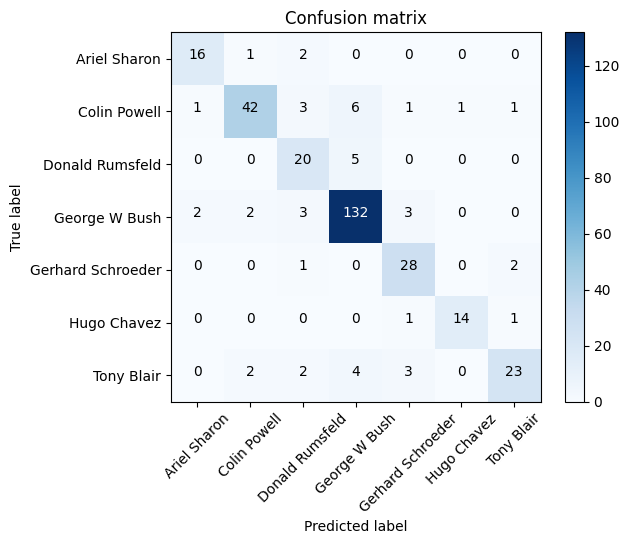

In [18]:
# use test set for prediction
y_pred = best_clf.predict(X_test)
print(accuracy_score(y_pred, y_test), "Accuracy score for best estimator")
print(classification_report(y_test, y_pred, target_names=target_names))
print(plot_confusion_matrix(confusion_matrix(y_test, y_pred, labels=range(n_classes)), target_names))
print(round((time() - t0), 1), "seconds to grid search and predict the test set")

Not much difference on using PCA.

In [23]:
def get_best_model_and_accuracy(model, params, X, y):
    grid = GridSearchCV(model,           # the model to grid search
                        params,          # the parameter set to try 
                        error_score=0.)  # if a parameter set raises an error, continue and set the performance as a big, fat 0
    grid.fit(X, y)           # fit the model and parameters
    # our classical metric for performance
    print("Best Accuracy: {}".format(grid.best_score_))
    # the best parameters that caused the best accuracy
    print("Best Parameters: {}".format(grid.best_params_))
    # the average time it took a model to fit to the data (in seconds)
    print("Average Time to Fit (s): {}".format(round(grid.cv_results_['mean_fit_time'].mean(), 3)))
    # the average time it took a model to predict out of sample data (in seconds)
    # this metric gives us insight into how this model will perform in real-time analysis
    print("Average Time to Score (s): {}".format(round(grid.cv_results_['mean_score_time'].mean(), 3)))

In [24]:
# We try to make a bigger GridSearch pipeline to include more components, scale, PCA, LDA, logistic regression
face_params = {'logistic__C':[1e-2, 1e-1, 1e0, 1e1, 1e2],
               'preprocessing__pca__n_components':[100, 150, 200, 250, 300],
               'preprocessing__pca__whiten':[True, False],
               'preprocessing__lda__n_components':range(1,7)} #[1, 2, 3, 4, 5, 6] max allowed= n_classes-1
pca = PCA()
lda = LinearDiscriminantAnalysis()

preprocessing = Pipeline([('scale', StandardScaler()), ('pca', pca), ('lda', lda)])
logreg = LogisticRegression(max_iter=10000)
face_pipeline = Pipeline(steps=[('preprocessing', preprocessing), ('logistic', logreg)])

get_best_model_and_accuracy(face_pipeline, face_params, X, y)

Best Accuracy: 0.8547793563176785
Best Parameters: {'logistic__C': 100.0, 'preprocessing__lda__n_components': 6, 'preprocessing__pca__n_components': 200, 'preprocessing__pca__whiten': True}
Average Time to Fit (s): 1.135
Average Time to Score (s): 0.021


The best accuracy we can reach is 85.47%.